## Adam convergence problem

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Synthetic example 1: online learning

We will solve the online optimization problem for function  $f_t(x) = \begin{cases} 1010x, \text{for t mod 101} = 1 \\ 
-10x, otherwise \end{cases}$

Online optimization task: $ F(x) = \sum_t f_t(x)  \to min_x$

with the constraint set $\mathcal{F} =[-1, 1]$

The analitical solution for this task is $x^*=-1$

In order to understand the problems of Adam, we denote the concept of "regret": $R_T = \sum\limits_{t=1}^T f_t(x_t) - \min\limits_{x \in \mathcal{F}} \sum\limits_{t=1}^T f_t(x)$

The regret should tend to zero during optimization, it implies that on average,
the model’s performance converges to the optimal one.

In [3]:
loss_buffer = []

In [4]:
import adashift.optimizers as ad_opt

In [5]:
def online_f_t(x, t):
    if t % 101 == 1:
        return 1010.0*x
    else:
        return -10.0*x
    
def f_min(t):
    if t % 101 == 1:
        return -1010.0
    else:
        return 10.0

In [6]:
def OnlineLearning(optimizer_type='Adam', alpha=1, lr_decay=True, eps=0.,
                   x_init=0.0, betas=(0.9, 0.99), amsgrad=False, max_step = 1000001):
    x = torch.tensor([x_init], requires_grad=True)
    lr = alpha
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], amsgrad=amsgrad, lr=lr, betas=betas, eps=eps)
    else:
        optimizer = ad_opt.AdaShift([x], lr=lr, betas=betas, eps=eps)
    
    
    regret_sum = 0
    time_steps = []
    avg_regret_history = []
    x_history = []
    
    if lr_decay:
        lambda_lr_decay = lambda step: alpha / np.sqrt(step + 1) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_decay)

    for step in range(1, max_step):
        # constraint
        x.data = x.data.clamp(-1, 1)
        
        loss = online_f_t(x, step)

        regret_sum += (loss.item() - f_min(step))
        regret_avg = regret_sum / step
    
        loss.backward()
        
        x_history.append(x.item())

        if step % 10000 == 0:
            time_steps.append(step)
            avg_regret_history.append(regret_avg)
        if step % 50000 == 0:
            print('step : {} loss: {} regret_avg : {} x: {}'.format(step, loss.item() , regret_avg, x.item()))

        optimizer.step()
                                
        if lr_decay:
            scheduler.step()
        optimizer.zero_grad()
                                                      
    return time_steps, avg_regret_history, x_history

In [7]:
time_steps, avg_regret_history, x_history = OnlineLearning()

step : 50000 loss: -9.889703750610352 regret_avg : 0.5064160318643972 x: 0.9889703989028931
step : 100000 loss: -9.864534378051758 regret_avg : 0.4067958696881495 x: 0.9864534735679626
step : 150000 loss: -9.865385055541992 regret_avg : 0.36496170430763314 x: 0.9865384697914124
step : 200000 loss: -9.87474250793457 regret_avg : 0.34069641541677526 x: 0.9874742031097412
step : 250000 loss: -9.886850357055664 regret_avg : 0.3244257141243443 x: 0.9886850118637085
step : 300000 loss: -9.899446487426758 regret_avg : 0.31256548273217555 x: 0.9899446368217468
step : 350000 loss: -9.911629676818848 regret_avg : 0.30343590262934034 x: 0.9911629557609558
step : 400000 loss: -9.92305850982666 regret_avg : 0.296132920313864 x: 0.9923058152198792
step : 450000 loss: -9.933679580688477 regret_avg : 0.29012169665317983 x: 0.9933679699897766
step : 500000 loss: -9.943526268005371 regret_avg : 0.28506324361689017 x: 0.9943526387214661
step : 550000 loss: -9.952676773071289 regret_avg : 0.28073099849078

In [8]:
amsgrad_time_steps, amsgrad_avg_regret_history, amsgrad_x_history = OnlineLearning(amsgrad=True)

step : 50000 loss: 9.866371154785156 regret_avg : 0.31438388655662536 x: -0.9866371154785156
step : 100000 loss: 9.961386680603027 regret_avg : 0.21818185344219207 x: -0.9961386919021606
step : 150000 loss: 9.991243362426758 regret_avg : 0.17665850755373638 x: -0.9991243481636047
step : 200000 loss: 10.0 regret_avg : 0.15222457282304763 x: -1.0
step : 250000 loss: 9.999848365783691 regret_avg : 0.13568644660758972 x: -0.999984860420227
step : 300000 loss: 9.997462272644043 regret_avg : 0.12354939424355825 x: -0.9997462034225464
step : 350000 loss: 9.993610382080078 regret_avg : 0.11415800917625427 x: -0.9993610382080078
step : 400000 loss: 9.989237785339355 regret_avg : 0.10661424065232276 x: -0.9989237785339355
step : 450000 loss: 9.984785079956055 regret_avg : 0.1003834655518002 x: -0.9984785318374634
step : 500000 loss: 9.980443954467773 regret_avg : 0.09512502759456634 x: -0.9980443716049194
step : 550000 loss: 9.976297378540039 regret_avg : 0.09061028428251093 x: -0.99762970209121

In [9]:
adashift_time_steps, adashift_avg_regret_history, adashift_x_history = OnlineLearning(optimizer_type='Adashift') 

step : 50000 loss: 9.873220443725586 regret_avg : 0.46133322309844194 x: -0.9873220920562744
step : 100000 loss: 10.0 regret_avg : 0.32524554844077674 x: -1.0
step : 150000 loss: 9.991798400878906 regret_avg : 0.2652160040167719 x: -0.9991798400878906
step : 200000 loss: 9.98381519317627 regret_avg : 0.22950586252776906 x: -0.9983815550804138
step : 250000 loss: 9.977197647094727 regret_avg : 0.2051678520629257 x: -0.9977197647094727
step : 300000 loss: 9.971391677856445 regret_avg : 0.18721873679219433 x: -0.9971391558647156
step : 350000 loss: 9.966115951538086 regret_avg : 0.173278321160408 x: -0.9966115951538086
step : 400000 loss: 9.961211204528809 regret_avg : 0.16204738431974314 x: -0.9961211085319519
step : 450000 loss: 9.956570625305176 regret_avg : 0.1527487501317842 x: -0.9956570863723755
step : 500000 loss: 9.952126502990723 regret_avg : 0.14488528773724288 x: -0.9952126741409302
step : 550000 loss: 9.947837829589844 regret_avg : 0.1381222433925691 x: -0.9947838187217712
st

Regret should tend to zero. As we can see it is done only for amsgrad.

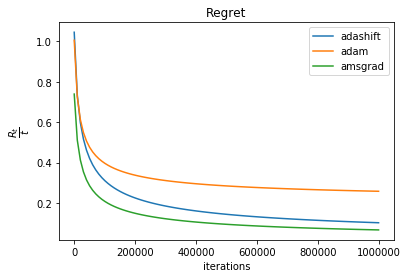

In [10]:
plt.title("Regret")
plt.plot(np.linspace(1, 1000001, 100), adashift_avg_regret_history, label='adashift')
plt.plot(np.linspace(1, 1000001, 100), avg_regret_history,label='adam')
plt.plot(np.linspace(1, 1000001, 100), amsgrad_avg_regret_history,label='amsgrad')
plt.xlabel("iterations")
plt.ylabel(r"$\dfrac{R_t}{t}$")
plt.legend()
plt.show()

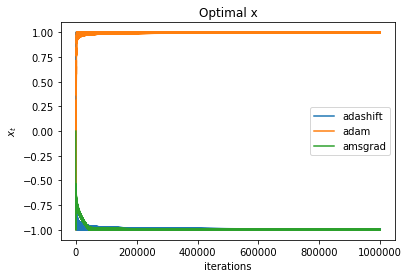

In [11]:
plt.title("Optimal x")
plt.plot(adashift_x_history, label='adashift')
plt.plot(x_history,label='adam')
plt.plot(amsgrad_x_history,label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()

# Synthetic example 2: stochastic case

Let's see on the similar task, but with stochasticity.

$\delta = 0.002$
C = 101

$f_t(x) = \begin{cases} Cx, \text{with p } =\frac{1+\delta}{C+1} \\ 
-x, otherwise \end{cases}$

Cost function is $\delta x$

In [12]:
delta = 0.02
C = 101
p = (1+delta)/(C + 1)

def stoch_f_t(x, t):
    if np.random.binomial(1,p):
        return C*x
    else:
        return -x

In [13]:
def StochLearning(optimizer_type='Adam', alpha=1e-3, lr_decay=True,\
                  eps=1e-10, betas=(0.0, 0.999), amsgrad=False, max_step = 1000001):
    
    x = torch.tensor([0.0], requires_grad=True)
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], lr=alpha, betas=betas, eps=eps, amsgrad=amsgrad)
    else:
        optimizer = ad_opt.AdaShift([x], lr=alpha, keep_num=1, betas=betas, eps=eps)

    time_steps = []
    avg_regret_history = []
    x_history = []
    loss_history = []
    print("Optimization with {}".format(optimizer_type))
    
    if lr_decay:
        lambda_lr_decay = lambda step: alpha / np.sqrt(step + 1) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_decay)

    for step in range(1, max_step):
        #x.data = x.data.clamp(-1.0, 1.0)

        loss = stoch_f_t(x, step)

        loss.backward()
        if step % 10000 == 0:
            x_history.append(x.item())
            loss_history.append(loss.item())
            time_steps.append(step)

        if step % 100000 == 0:
            print ('step : ', step, '  loss : ', loss.item(), ' x:', x.item())
                                 
        optimizer.step()   

        if lr_decay:
            scheduler.step()
        
        optimizer.zero_grad()
            
    return time_steps, loss_history, x_history

In [14]:
lr = 1e-3
time_steps, loss_history, x_history = StochLearning(alpha=lr, lr_decay=False, max_step=10000000)

Optimization with Adam
step :  100000   loss :  -1.1847261190414429  x: 1.1847261190414429
step :  200000   loss :  -1.4070461988449097  x: 1.4070461988449097
step :  300000   loss :  -1.7301219701766968  x: 1.7301219701766968
step :  400000   loss :  -2.104252576828003  x: 2.104252576828003
step :  500000   loss :  -2.7960855960845947  x: 2.7960855960845947
step :  600000   loss :  -3.5971755981445312  x: 3.5971755981445312
step :  700000   loss :  -4.240509033203125  x: 4.240509033203125
step :  800000   loss :  -4.502536773681641  x: 4.502536773681641
step :  900000   loss :  -4.662587642669678  x: 4.662587642669678
step :  1000000   loss :  -5.070318698883057  x: 5.070318698883057
step :  1100000   loss :  -5.384920597076416  x: 5.384920597076416
step :  1200000   loss :  -5.2494916915893555  x: 5.2494916915893555
step :  1300000   loss :  -5.3970627784729  x: 5.3970627784729
step :  1400000   loss :  -5.596741676330566  x: 5.596741676330566
step :  1500000   loss :  -6.00841426849

In [15]:
adashift_time_steps, adashift_loss_history, adashift_x_history = \
                    StochLearning(optimizer_type='Adashift',lr_decay=False, max_step=10000000)

Optimization with Adashift
step :  100000   loss :  0.31325533986091614  x: -0.31325533986091614
step :  200000   loss :  0.28532645106315613  x: -0.28532645106315613
step :  300000   loss :  0.8368154168128967  x: -0.8368154168128967
step :  400000   loss :  1.0624598264694214  x: -1.0624598264694214
step :  500000   loss :  1.8906928300857544  x: -1.8906928300857544
step :  600000   loss :  2.344602108001709  x: -2.344602108001709
step :  700000   loss :  2.448505163192749  x: -2.448505163192749
step :  800000   loss :  2.5806972980499268  x: -2.5806972980499268
step :  900000   loss :  2.9236128330230713  x: -2.9236128330230713
step :  1000000   loss :  2.4929535388946533  x: -2.4929535388946533
step :  1100000   loss :  2.7226791381835938  x: -2.7226791381835938
step :  1200000   loss :  2.6651761531829834  x: -2.6651761531829834
step :  1300000   loss :  2.685107469558716  x: -2.685107469558716
step :  1400000   loss :  2.215848684310913  x: -2.215848684310913
step :  1500000   lo

In [16]:
ams_time_steps, ams_loss_history, ams_x_history = StochLearning(alpha=lr, amsgrad=True, 
                                                                lr_decay=False, max_step=10000000)

Optimization with Adam
step :  100000   loss :  0.06807340681552887  x: -0.06807340681552887
step :  200000   loss :  0.1619931012392044  x: -0.1619931012392044
step :  300000   loss :  0.20775218307971954  x: -0.20775218307971954
step :  400000   loss :  0.2950662672519684  x: -0.2950662672519684
step :  500000   loss :  0.49955493211746216  x: -0.49955493211746216
step :  600000   loss :  0.35960322618484497  x: -0.35960322618484497
step :  700000   loss :  0.13698606193065643  x: -0.13698606193065643
step :  800000   loss :  0.09306208044290543  x: -0.09306208044290543
step :  900000   loss :  0.31118008494377136  x: -0.31118008494377136
step :  1000000   loss :  0.3847825825214386  x: -0.3847825825214386
step :  1100000   loss :  0.8786011338233948  x: -0.8786011338233948
step :  1200000   loss :  1.1681876182556152  x: -1.1681876182556152
step :  1300000   loss :  0.8730359673500061  x: -0.8730359673500061
step :  1400000   loss :  0.822638750076294  x: -0.822638750076294
step :  

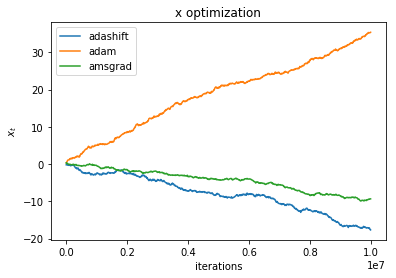

In [23]:
plt.title("x optimization")
x = np.arange(len(adashift_x_history))
plt.plot(xx, adashift_x_history, label='adashift')
plt.plot(xx, x_history,label='adam')
plt.plot(xx, ams_x_history, label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()